In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2
import matplotlib.pyplot as plt

print("All required libraries imported successfully.")
print("These libraries handle data processing, deep learning models, and visualizations.")

All required libraries imported successfully.
These libraries handle data processing, deep learning models, and visualizations.


In [ ]:
apple_df = pd.read_csv('/content/apple_stock.csv')
tesla_df = pd.read_csv('/content/tesla_stock.csv')

print("Apple's Stock Dataset - First 10 Rows:")
print(apple_df.head(10))

print("\nTesla's Stock Dataset - First 10 Rows:")
print(tesla_df.head(10))

Apple's Stock Dataset - First 10 Rows:
         Date  Close/Last     Volume      Open      High       Low
0  02/28/2020     $273.36  106721200   $257.26   $278.41   $256.37
1  02/27/2020     $273.52   80151380    $281.1      $286   $272.96
2  02/26/2020     $292.65   49678430   $286.53   $297.88    $286.5
3  02/25/2020     $288.08   57668360   $300.95   $302.53   $286.13
4  02/24/2020     $298.18   55548830   $297.26   $304.18   $289.23
5  02/21/2020     $313.05   32426420   $318.62   $320.45    $310.5
6  02/20/2020      $320.3   25141490   $322.63   $324.65   $318.21
7  02/19/2020     $323.62   23495990      $320   $324.57      $320
8  02/18/2020        $319   38190550   $315.36   $319.75   $314.61
9  02/14/2020     $324.95   20028450   $324.74   $325.98   $322.85

Tesla's Stock Dataset - First 10 Rows:
        Date       Open       High        Low      Close    Volume  Adj Close
0  6/29/2010  19.000000  25.000000  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.

In [ ]:
def preprocess_data(apple_df, tesla_df):
    print("\nPreprocessed dataset")
    try:
        #renaming 'Close/Last' to 'Close' for Apple
        apple_df = apple_df.rename(columns={' Close/Last': 'Close'}) # Corrected column name with leading space

        #drropping 'Adj Close' from Tesla dataset
        tesla_df = tesla_df.drop(columns=['Adj Close'], errors='ignore')

        #strip leading/trailing spaces from column names
        apple_df.columns = apple_df.columns.str.strip()
        tesla_df.columns = tesla_df.columns.str.strip()

        # Define expected columns
        columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        #selectingg only required columns
        apple_df = apple_df[columns]
        tesla_df = tesla_df[columns]

        #processed data
        print("\nProcessed Apple Dataset - First 5 Rows:")
        print(apple_df.head(5))
        print(f"Apple Columns: {list(apple_df.columns)}")

        print("\nProcessed Tesla Dataset - First 5 Rows:")
        print(tesla_df.head(5))
        print(f"Tesla Columns: {list(tesla_df.columns)}")

        return apple_df, tesla_df
    except KeyError as e:
        print(f"Error: Missing column {e}. Please check column names in the datasets.")
        print(f"Apple columns: {list(apple_df.columns)}")
        print(f"Tesla columns: {list(tesla_df.columns)}")
        raise
    except Exception as e:
        print(f"Error preprocessing data: {e}")
        raise

apple_df, tesla_df = preprocess_data(apple_df, tesla_df)


Preprocessed dataset

Processed Apple Dataset - First 5 Rows:
         Date      Open      High       Low     Close     Volume
0  02/28/2020   $257.26   $278.41   $256.37   $273.36  106721200
1  02/27/2020    $281.1      $286   $272.96   $273.52   80151380
2  02/26/2020   $286.53   $297.88    $286.5   $292.65   49678430
3  02/25/2020   $300.95   $302.53   $286.13   $288.08   57668360
4  02/24/2020   $297.26   $304.18   $289.23   $298.18   55548830
Apple Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

Processed Tesla Dataset - First 5 Rows:
        Date       Open   High        Low      Close    Volume
0  6/29/2010  19.000000  25.00  17.540001  23.889999  18766300
1  6/30/2010  25.790001  30.42  23.299999  23.830000  17187100
2   7/1/2010  25.000000  25.92  20.270000  21.959999   8218800
3   7/2/2010  23.000000  23.10  18.709999  19.200001   5139800
4   7/6/2010  20.000000  20.00  15.830000  16.110001   6866900
Tesla Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volum

In [ ]:
def prepare_data(df, look_back=60, features=['Open', 'High', 'Low', 'Close', 'Volume']):
    print("\nData preparation for modeling...")
    try:
        for col in ['Open', 'High', 'Low', 'Close']:
            if df[col].dtype == 'object':
                df[col] = df[col].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float) # Removing '$' and ',' and converting to float
            else:
                df[col] = df[col].astype(float)

        data = df[features].values
        print(f"Using features: {features}")

        #scaling data to [0, 1] using minmax-scaler
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)
        print("\nSample scaled data (first 5 rows):")
        print(pd.DataFrame(scaled_data, columns=features).head(5))

        X, y = [], []
        for i in range(look_back, len(scaled_data)):
            X.append(scaled_data[i-look_back:i])
            y.append(scaled_data[i, features.index('Close')])

        X, y = np.array(X), np.array(y)

        #80% training data
        #20% testing data
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        print(f"\nData shapes:")
        print(f"Training data: X_train={X_train.shape}, y_train={y_train.shape}")
        print(f"Testing data: X_test={X_test.shape}, y_test={y_test.shape}")

        return X_train, X_test, y_train, y_test, scaler
    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

print("\nPreparing Apple data...")
X_train_apple, X_test_apple, y_train_apple, y_test_apple, scaler_apple = prepare_data(apple_df.copy())

print("\nPreparing Tesla data...")
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla, scaler_tesla = prepare_data(tesla_df.copy())


Preparing Apple data...

Data preparation for modeling...
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']

Sample scaled data (first 5 rows):
       Open      High       Low     Close    Volume
0  0.771523  0.834050  0.772861  0.818943  0.211402
1  0.852242  0.859527  0.829120  0.819481  0.152499
2  0.870627  0.899403  0.875036  0.883813  0.084944
3  0.919451  0.915011  0.873782  0.868444  0.102656
4  0.906957  0.920550  0.884294  0.902409  0.097958

Data shapes:
Training data: X_train=(1966, 60, 5), y_train=(1966,)
Testing data: X_test=(492, 60, 5), y_test=(492,)

Preparing Tesla data...

Data preparation for modeling...
Using features: ['Open', 'High', 'Low', 'Close', 'Volume']

Sample scaled data (first 5 rows):
       Open      High       Low     Close    Volume
0  0.010533  0.030460  0.009645  0.029936  0.503377
1  0.035539  0.050184  0.031347  0.029714  0.460748
2  0.032630  0.033808  0.019931  0.022795  0.218659
3  0.025264  0.023545  0.014053  0.012581  0.135544
4  

In [ ]:
#modelling
def build_gru(look_back, n_features):
    #simple gru model
    model = Sequential([
        GRU(30, input_shape=(look_back, n_features), kernel_regularizer=L2(0.01)), #look_back to observe past data
        Dropout(0.2), #to prevent overfitting
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_lstm(look_back, n_features):
    #simple lstm model
    model = Sequential([
        LSTM(30, input_shape=(look_back, n_features), kernel_regularizer=L2(0.01)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_bidirectional_lstm(look_back, n_features):
    #bidirectional lstm model
    model = Sequential([
        Bidirectional(LSTM(30, kernel_regularizer=L2(0.01)), input_shape=(look_back, n_features)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_bidirectional_gru(look_back, n_features):
   #bidirectional gru model
    model = Sequential([
        Bidirectional(GRU(30, kernel_regularizer=L2(0.01)), input_shape=(look_back, n_features)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

print("\nDefining neural network models for stock price prediction...")
look_back = 60
n_features = 5  # ['Open', 'High', 'Low', 'Close', 'Volume']
models = {
    'GRU': build_gru(look_back, n_features),
    'LSTM': build_lstm(look_back, n_features),
    'Bidirectional LSTM': build_bidirectional_lstm(look_back, n_features),
    'Bidirectional GRU': build_bidirectional_gru(look_back, n_features)
}

#model details
for name, model in models.items():
    print(f"\nModel: {name}")
    print("This model uses a neural network to predict stock prices based on past data.")
    print("Summary (layers and parameters):")
    model.summary()
    print("\nDetailed Configuration:")
    print(model.get_config())


Defining neural network models for stock price prediction...

Model: GRU
This model uses a neural network to predict stock prices based on past data.
Summary (layers and parameters):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30)             │         3,330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361 (13.13 KB)

 Trainable params: 3,361 (13.13 KB)

 Non-trainable params: 0 (0.00 B)


Detailed Configuration:
{'name': 'sequential_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 60, 5), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_4'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'GRU', 'config': {'name': 'gru_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 30, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.i

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30)             │         4,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,351 (17.00 KB)

 Trainable params: 4,351 (17.00 KB)

 Non-trainable params: 0 (0.00 B)


Detailed Configuration:
{'name': 'sequential_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 60, 5), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_5'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 30, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 60)             │         8,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,701 (33.99 KB)

 Trainable params: 8,701 (33.99 KB)

 Non-trainable params: 0 (0.00 B)


Detailed Configuration:
{'name': 'sequential_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 60, 5), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_6'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Bidirectional', 'config': {'name': 'bidirectional_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'forward_lstm_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': Fals

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 60)             │         6,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)


Detailed Configuration:
{'name': 'sequential_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 60, 5), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_7'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Bidirectional', 'config': {'name': 'bidirectional_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'merge_mode': 'concat', 'layer': {'module': 'keras.layers', 'class_name': 'GRU', 'config': {'name': 'forward_gru_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False,

In [ ]:
#training
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, callbacks=[early_stopping], verbose=1)

    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"\n{model_name} Metrics:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    return model, y_test_pred, {'train_rmse': train_rmse, 'train_mae': train_mae,
                                'test_rmse': test_rmse, 'test_mae': test_mae}

results_apple = {}
for name, model in models.items():
    model, y_test_pred, metrics = train_and_evaluate(
        model, X_train_apple, y_train_apple, X_test_apple, y_test_apple, name)
    results_apple[name] = {'model': model, 'y_test_pred': y_test_pred, 'metrics': metrics}

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1844 - val_loss: 0.0706
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0656 - val_loss: 0.0416
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0402 - val_loss: 0.0268
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0269 - val_loss: 0.0187
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0198 - val_loss: 0.0140
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0152 - val_loss: 0.0109
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0

In [ ]:
#fine tuning the best performing model which was bidirectional gru based on the scores

def fine_tune_model(model, X_train, y_train, X_test, y_test, model_name, epochs=50, batch_size=32):
    for layer in model.layers[:1]:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[early_stopping], verbose=1)

    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = 100 * np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10)))

    print(f"\nFine-Tuned {model_name} Metrics on Tesla's Dataset:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test MAPE: {test_mape:.2f}% (Accuracy: {100 - test_mape:.2f}%)")

    return model, y_test_pred, {'train_rmse': train_rmse, 'train_mae': train_mae,
                                'test_rmse': test_rmse, 'test_mae': test_mae, 'test_mape': test_mape}

best_model_name = min(results_apple, key=lambda x: results_apple[x]['metrics']['test_rmse'])
best_model = results_apple[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

model, y_pred_tesla, metrics_tesla = fine_tune_model(
    best_model, X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla, best_model_name)


Best Model: Bidirectional GRU
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0017 - val_loss: 0.0013

Fine-Tuned Bidirectional GRU Metrics on Tesla's Dataset:
Train RMSE: 0.0266
Train MAE: 0.0183
Test RMSE: 0.0324
Test MAE: 0.0253
Test MAPE: 13.31% (Accuracy: 86.69%)


In [ ]:
#summarization

best_apple_model = min(results_apple, key=lambda x: results_apple[x]['metrics']['test_rmse'])

print(f"\nApple {best_apple_model} Metrics:")
print(f"Train RMSE: {results_apple[best_apple_model]['metrics']['train_rmse']:.4f}")
print(f"Train MAE: {results_apple[best_apple_model]['metrics']['train_mae']:.4f}")
print(f"Test RMSE: {results_apple[best_apple_model]['metrics']['test_rmse']:.4f}")
print(f"Test MAE: {results_apple[best_apple_model]['metrics']['test_mae']:.4f}")

print(f"\nTesla Fine-Tuned {best_apple_model} Metrics:")
print(f"Train RMSE: {metrics_tesla['train_rmse']:.4f}")
print(f"Train MAE: {metrics_tesla['train_mae']:.4f}")
print(f"Test RMSE: {metrics_tesla['test_rmse']:.4f}")
print(f"Test MAE: {metrics_tesla['test_mae']:.4f}")


Apple Bidirectional GRU Metrics:
Train RMSE: 0.0132
Train MAE: 0.0102
Test RMSE: 0.0069
Test MAE: 0.0058

Tesla Fine-Tuned Bidirectional GRU Metrics:
Train RMSE: 0.0266
Train MAE: 0.0183
Test RMSE: 0.0324
Test MAE: 0.0253


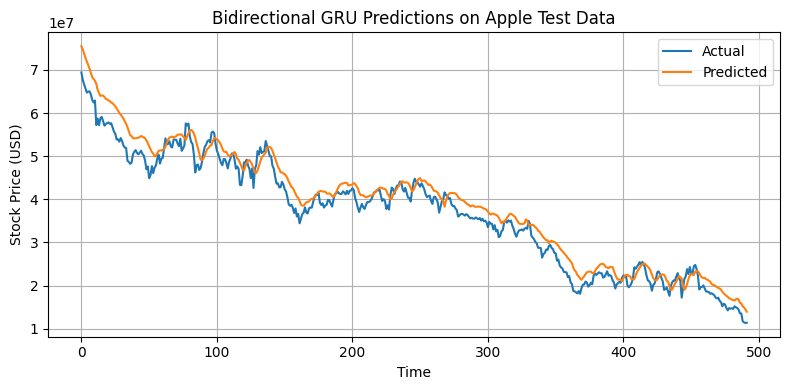

In [ ]:
#actual vs predicted price on apple's dataset

y_test_apple_inv = scaler_apple.inverse_transform(
    np.hstack([np.zeros((len(y_test_apple), 4)), y_test_apple.reshape(-1, 1)]))[:, 4]
y_pred_apple_inv = scaler_apple.inverse_transform(
    np.hstack([np.zeros((len(results_apple[best_apple_model]['y_test_pred']), 4)),
               results_apple[best_apple_model]['y_test_pred']]))[:, 4]

plt.figure(figsize=(8, 4))
plt.plot(y_test_apple_inv, label='Actual')
plt.plot(y_pred_apple_inv, label='Predicted')
plt.title(f'{best_apple_model} Predictions on Apple Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

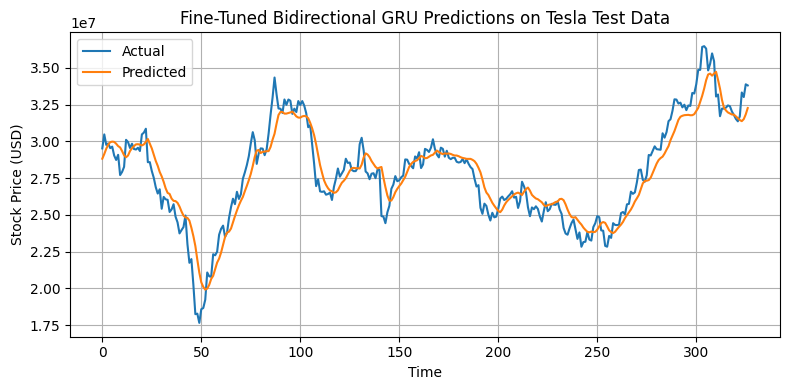

In [ ]:
#actual vs predicted price on tesla's dataset

y_test_tesla_inv = scaler_tesla.inverse_transform(
    np.hstack([np.zeros((len(y_test_tesla), 4)), y_test_tesla.reshape(-1, 1)]))[:, 4]
y_pred_tesla_inv = scaler_tesla.inverse_transform(
    np.hstack([np.zeros((len(y_pred_tesla), 4)), y_pred_tesla]))[:, 4]

plt.figure(figsize=(8, 4))
plt.plot(y_test_tesla_inv, label='Actual')
plt.plot(y_pred_tesla_inv, label='Predicted')
plt.title(f'Fine-Tuned {best_apple_model} Predictions on Tesla Test Data')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#final verdicts

print("\nVerdict:")
print(f"{best_apple_model} achieved a Test RMSE of {results_apple[best_apple_model]['metrics']['test_rmse']:.4f} and Test MAE of {results_apple[best_apple_model]['metrics']['test_mae']:.4f} on Apple data, indicating strong predictive performance.")
print(f"Fine-tuning on Tesla yielded a Test RMSE of {metrics_tesla['test_rmse']:.4f} and Test MAE of {metrics_tesla['test_mae']:.4f}, reflecting reasonable performance despite higher volatility.")


Verdict:
Bidirectional GRU achieved a Test RMSE of 0.0069 and Test MAE of 0.0058 on Apple data, indicating strong predictive performance.
Fine-tuning on Tesla yielded a Test RMSE of 0.0324 and Test MAE of 0.0253, reflecting reasonable performance despite higher volatility.
